In [1]:
import os
import torch
import clip
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score

In [2]:
k=5
batch_size= 16
FINE_TUNE = True  # Set to False to skip training
TRAIN_LAST_LAYER_ONLY = False  # Set to False to fine-tune entire model
epochs = 1
lr = 1e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# image_size = (224, 224)
# normalize_mean = [0.485, 0.456, 0.406]
# normalize_std = [0.229, 0.224, 0.225]

In [3]:
class ImageTextDataset(Dataset):
    def __init__(self, root_folder, transform):
        self.transform = transform
        self.img_paths = []
        self.labels = []
        # Walk through subfolders
        for label_name in os.listdir(root_folder):
            label_path = os.path.join(root_folder, label_name)
            if os.path.isdir(label_path):
                for img_file in os.listdir(label_path):
                    self.img_paths.append(os.path.join(label_path, img_file))
                    self.labels.append(label_name)  # folder name as label

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx]).convert("RGB")
        image = self.transform(image)
        label = self.labels[idx]
        return image, label, os.path.basename(self.img_paths[idx])


In [4]:
model, preprocess = clip.load("ViT-B/32", device=device)

if not FINE_TUNE:
    for param in model.parameters():
        param.requires_grad = False
elif TRAIN_LAST_LAYER_ONLY:
    for name, param in model.named_parameters():
        if "proj" in name or "visual.proj" in name:
            param.requires_grad = True
        else:
            param.requires_grad = False
else:
    for param in model.parameters():
        param.requires_grad = True


In [15]:
def fine_tune_clip(train_loader, model, epochs=epochs, lr=lr):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.CrossEntropyLoss()
    final_loss = None

    for epoch in range(epochs):
        running_loss = 0.0

        for images, labels, _ in train_loader:
            images = images.to(device)

            # Tokenize text labels
            texts = clip.tokenize(labels).to(device)

            # Forward pass
            image_features = model.encode_image(images)
            text_features = model.encode_text(texts)

            # Normalize features
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)

            # Compute logits
            logits_per_image = image_features @ text_features.t()
            logits_per_text = text_features @ image_features.t()

            # Diagonal ground truth
            ground_truth = torch.arange(len(images), device=device)

            # Symmetric contrastive loss
            loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        final_loss = running_loss / len(train_loader)
        print(f"Epoch {epoch+1}/{epochs} - Loss: {final_loss:.4f}")

    return final_loss





# def fine_tune_clip(train_loader, model, epochs=epochs, lr=lr):
#     model.train()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#     loss_fn = torch.nn.CrossEntropyLoss()

#     for epoch in range(epochs):
#         for images, labels, _ in train_loader:
#             images = images.to(device)

#             # Prepare text tokens for labels
#             texts = clip.tokenize(labels).to(device)
            
#             # Forward pass
#             image_features = model.encode_image(images)
#             text_features = model.encode_text(texts)
            
#             # Normalize embeddings
#             image_features = image_features / image_features.norm(dim=-1, keepdim=True)
#             text_features = text_features / text_features.norm(dim=-1, keepdim=True)

#             torch.autograd.set_detect_anomaly(True)

            
#             # Compute logits: image-text similarity
#             logits_per_image = image_features @ text_features.t()
#             logits_per_text = text_features @ image_features.t()
            
#             # Labels are diagonal (correct pairs)
#             ground_truth = torch.arange(len(images), device=device)

#             # Compute contrastive loss (sum of two cross-entropy losses)
#             loss = (loss_fn(logits_per_image, ground_truth) + loss_fn(logits_per_text, ground_truth)) / 2

#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         print(f"Epoch {epoch+1}/{epochs} Loss: {loss.item():.4f}")


In [16]:
def encode_images(image_folder, model, preprocess):
    image_paths = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder)])
    images = [preprocess(Image.open(p).convert("RGB")) for p in image_paths]
    images = torch.stack(images).to(device)

    with torch.no_grad():
        features = model.encode_image(images)
        features /= features.norm(dim=-1, keepdim=True)
    return features, image_paths


In [17]:
def retrieve(query_features, gallery_features, gallery_paths, k):
    similarities = query_features @ gallery_features.T  # cosine similarity matrix
    topk_values, topk_indices = similarities.topk(k, dim=-1)

    results = []
    for i in range(query_features.shape[0]):
        retrieved = [gallery_paths[idx] for idx in topk_indices[i].cpu().numpy()]
        results.append(retrieved)
    return results


In [18]:
def visualize_retrieval(query_paths, retrieval_results):
    for i, query_path in enumerate(query_paths):
        plt.figure(figsize=(15, 5))
        
        # Show query
        plt.subplot(1, 6, 1)
        plt.title("Query")
        plt.axis("off")
        plt.imshow(Image.open(query_path))
        
        # Show retrieved images
        for j, img_path in enumerate(retrieval_results[i]):
            plt.subplot(1, 6, j+2)
            plt.title(f"Rank {j+1}")
            plt.axis("off")
            plt.imshow(Image.open(img_path))
        plt.show()


In [19]:
def compute_accuracy(query_labels, retrieval_results, gallery_labels):
    correct = 0
    for i, retrieved_imgs in enumerate(retrieval_results):
        # Check if any retrieved image has the same label as query
        query_label = query_labels[i]
        retrieved_labels = [gallery_labels[os.path.basename(p)] for p in retrieved_imgs]
        if query_label in retrieved_labels:
            correct += 1
    return correct / len(query_labels)


In [20]:
import os
import json
from datetime import datetime

import os
import json
from datetime import datetime

def save_metrics_json(
    model_name,
    top_k_accuracy,
    batch_size,
    is_finetuned,
    num_classes=None,
    runtime=None,
    loss_function="CrossEntropyLoss",
    num_epochs=None,
    final_loss=None
):
    project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
    results_dir = os.path.join(project_root, "results")
    os.makedirs(results_dir, exist_ok=True)

    timestamp = datetime.now().strftime("%Y%m%d-%H%M")
    out_path = os.path.join(results_dir, f"{model_name}_metrics_{timestamp}.json")

    metrics = {
        "model_name": model_name,
        "run_id": timestamp,
        "top_k": 10,
        "top_k_accuracy": round(top_k_accuracy, 4),
        "batch_size": batch_size,
        "is_finetuned": is_finetuned,
        "num_classes": num_classes,
        "runtime_seconds": round(runtime, 2) if runtime else None,
        "loss_function": loss_function,
        "num_epochs": num_epochs,
        "final_train_loss": round(final_loss, 4) if final_loss is not None else None
    }

    with open(out_path, "w") as f:
        json.dump(metrics, f, indent=2)

    print(f"📁 Metrics saved to: {os.path.abspath(out_path)}")

Epoch 1/1 - Loss: 2.2212
✅ Submission saved to: c:\Users\MyPc\OneDrive\Documenti\Universita\Data Science\Intro to ML\Competition\ml-project-intro\submissions\sub_clip.json
📊 Top-5 Accuracy: 0.5000
📁 Metrics saved to: c:\Users\MyPc\OneDrive\Documenti\Universita\Data Science\Intro to ML\Competition\ml-project-intro\results\clip-vit-b32_metrics_20250522-1906.json


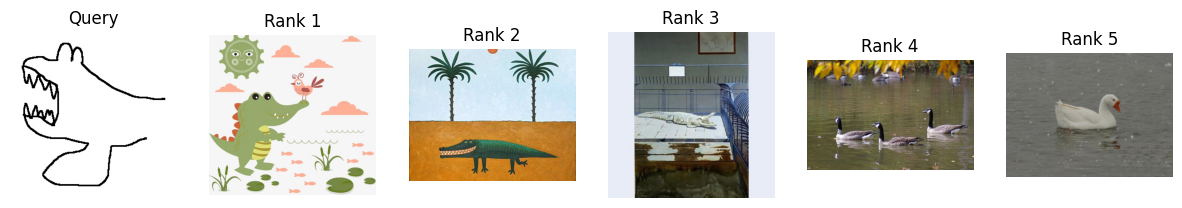

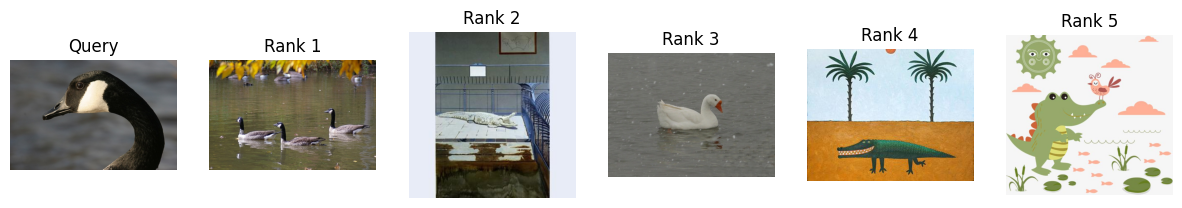

In [21]:
import time
start_time = time.time()

# --- Path setup ---
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
DATA_DIR = os.path.join(BASE_DIR, "data")

training_dir = os.path.join(DATA_DIR, "training")
query_dir = os.path.join(DATA_DIR, "test", "query")
gallery_dir = os.path.join(DATA_DIR, "test", "gallery")

# --- Dataset ---
transform = preprocess
train_dataset = ImageTextDataset(training_dir, transform=preprocess)
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

# --- Optional fine-tuning ---
if FINE_TUNE:
    final_loss = fine_tune_clip(train_loader, model)
else:
    final_loss = None

# --- Feature encoding ---
gallery_features, gallery_paths = encode_images(gallery_dir, model, preprocess)
query_features, query_paths = encode_images(query_dir, model, preprocess)

# --- Retrieval ---
retrieval_results = retrieve(query_features, gallery_features, gallery_paths, k=k)

# --- Save submission JSON ---
submission = []
for i, qname in enumerate(query_paths):
    submission.append({
        "filename": os.path.basename(qname),
        "samples": [os.path.basename(p) for p in retrieval_results[i]]
    })

sub_dir = os.path.join(BASE_DIR, "submissions")
os.makedirs(sub_dir, exist_ok=True)
sub_path = os.path.join(sub_dir, "sub_clip.json")
with open(sub_path, "w") as f:
    json.dump(submission, f, indent=2)

print(f"✅ Submission saved to: {sub_path}")

# --- Compute top-k accuracy ---
def calculate_top_k_accuracy(query_paths, retrievals, k=10):
    correct = 0
    for i, qname in enumerate(query_paths):
        q_class = os.path.basename(qname).split("_")[0]
        retrieved_classes = [os.path.basename(p).split("_")[0] for p in retrievals[i]]
        if q_class in retrieved_classes:
            correct += 1
    acc = correct / len(query_paths)
    print(f"📊 Top-{k} Accuracy: {acc:.4f}")
    return acc

top_k_acc = calculate_top_k_accuracy(query_paths, retrieval_results, k=k)

# --- Save metrics ---
runtime = time.time() - start_time
save_metrics_json(
    model_name="clip-vit-b32",  # o altro, se diverso
    top_k_accuracy=top_k_acc,
    batch_size=batch_size,
    is_finetuned=FINE_TUNE,
    num_classes=None,
    runtime=runtime,
    loss_function="CrossEntropyLoss",
    num_epochs=epochs,
    final_loss=final_loss
)

# --- Optional visualization ---
visualize_retrieval(query_paths, retrieval_results)


In [22]:
# BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# DATA_DIR = os.path.join(BASE_DIR, "data")

# training_dir = os.path.join(DATA_DIR, "training")
# query_dir = os.path.join(DATA_DIR, "test", "query")
# gallery_dir = os.path.join(DATA_DIR, "test", "gallery")

# transform = preprocess

# train_dataset = ImageTextDataset(training_dir, transform=preprocess)
# train_loader = DataLoader(train_dataset, batch_size, shuffle=True)

# if FINE_TUNE:
#     fine_tune_clip(train_loader, model)


# gallery_features, gallery_paths = encode_images(gallery_dir, model, preprocess)
# query_features, query_paths = encode_images(query_dir, model, preprocess)

# retrieval_results = retrieve(query_features, gallery_features, gallery_paths, k=k)
# visualize_retrieval(query_paths, retrieval_results)